In [1]:
!pip install pytorch-forecasting pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 6.6 MB/s 
     |████████████████████████████████| 798 kB 32.2 MB/s 
     |████████████████████████████████| 308 kB 34.7 MB/s 
     |████████████████████████████████| 529 kB 48.0 MB/s 
     |████████████████████████████████| 87 kB 6.6 MB/s 
     |████████████████████████████████| 81 kB 5.4 MB/s 
     |████████████████████████████████| 209 kB 40.9 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 112 kB 44.2 MB/s 
     |████████████████████████████████| 147 kB 41.5 MB/s 
     |████████████████████████████████| 50 kB 2.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e027869dc7b15ad395bdca5337d1b4d722785c4318c4a3e244f4214a58799727
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
  Created

In [2]:
import os
import random
import warnings
warnings.filterwarnings("ignore")
import copy
from pathlib import Path


import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

random.seed(30)
np.random.seed(30)

In [57]:
data = pd.read_csv('https://raw.githubusercontent.com/dunfrey/tft-experiments/main/df_final.csv')

data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['new_confirmed'] = data['new_confirmed'].astype(float)

data["time_idx"] = data.index
data['level'] = pd.qcut(data['new_confirmed'], 5, labels=False).astype(str).astype("category")

data['aqi'] = pd.qcut(data['aqi'], 6, labels=False).astype(str).astype("category")

# add additional features
data["day_of_week"] = data.date.dt.dayofweek.astype(str).astype("category")  # categories have be strings
data["week_of_year"] = data.date.dt.weekofyear.astype(str).astype("category")  # categories have be strings
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings


def holiday_map(x):
    return {0:'non_holiday', 1:'holiday'}[x]
data["holiday"] = data["holiday"].map(holiday_map).astype('category')

In [4]:
data

,date,aqi,pm25,pm10,co,o3,no2,so2,temperature,humidity,...,parks,transit stations,workplaces,residential,new_confirmed,time_idx,level,day_of_week,week_of_year,month
0,2020-02-25,1,34.0,12.0,3.7,10.2,7.4,0.6,25.2,82.0,...,17.0,-46.0,-66.0,14.0,1.0,0,0,1,9,2
1,2020-02-26,0,25.0,10.0,4.6,5.3,11.5,1.6,22.0,95.0,...,-39.0,-19.0,-15.0,7.0,0.0,1,0,2,9,2
2,2020-02-27,0,21.0,10.0,2.8,12.6,8.7,0.6,17.7,92.0,...,-12.0,5.0,10.0,1.0,0.0,2,0,3,9,2
3,2020-02-28,0,25.0,16.0,2.8,8.6,11.0,1.1,18.3,84.3,...,-7.0,7.0,14.0,0.0,1.0,3,0,4,9,2
4,2020-02-29,0,30.0,10.0,3.7,9.0,8.7,0.6,20.0,92.5,...,13.0,6.0,6.0,2.0,0.0,4,0,5,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,2021-12-29,3,59.0,21.0,2.8,24.0,10.6,1.1,20.1,86.5,...,-23.0,-23.0,-32.0,12.0,0.0,673,0,2,52,12
674,2021-12-30,2,42.0,14.0,2.8,18.7,10.6,1.1,19.7,88.0,...,-41.0,-26.0,-39.0,11.0,0.0,674,0,3,52,12
675,2021-12-31,0,21.0,9.0,3.7,11.8,10.6,0.6,19.5,92.0,...,-61.0,-50.0,-66.0,19.0,0.0,675,0,4,52,12
676,2022-01-01,2,46.0,14.0,3.7,11.8,7.4,0.6,21.6,82.1,...,-62.0,-59.0,-64.0,9.0,0.0,676,0,5,52,1


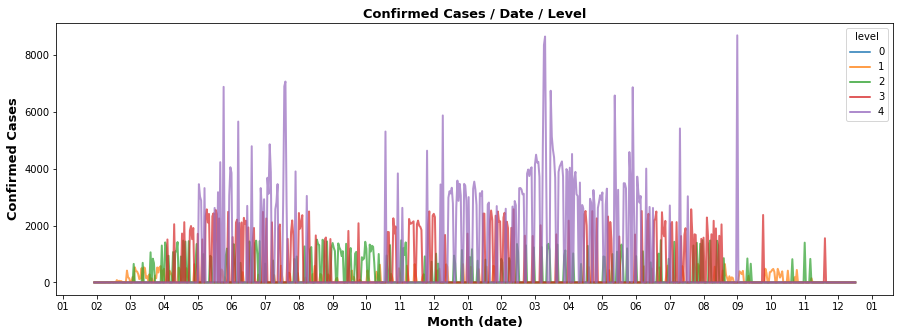

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
sns.lineplot(x='date',y='new_confirmed',hue='level',data=(data.groupby(['date', 'level']).new_confirmed.sum().rename('new_confirmed')
                                                       .reset_index().sort_values('date', ascending = True, ignore_index=True)), linewidth = 2, alpha = 0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
ax.set_xlabel('Month (date)', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Confirmed Cases', color='black', fontweight='bold', fontsize=13)
ax.set_title('Confirmed Cases / Date / Level', fontweight = 'bold', fontsize = 13);

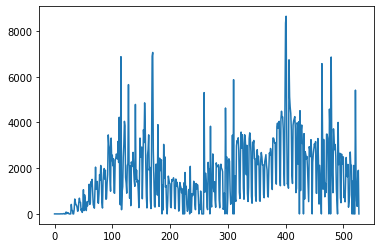

In [58]:
data[:-150]['new_confirmed'].plot()

In [59]:
data = data[:-150]

# Dataset Building

In [89]:
max_prediction_length = 14
max_encoder_length = max_prediction_length*3
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="new_confirmed",
    group_ids=["level", "day_of_week"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_categoricals=["month", "day_of_week", "week_of_year"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        "new_confirmed", 'aqi', 'pm25', 'pm10', 'co', 'o3', 'no2', 'so2', 'temperature',
        'humidity', 'retail and recreation', 'grocery and pharmacy',
        'parks', 'transit stations', 'workplaces', 'residential',
    ],
    target_normalizer=GroupNormalizer(
        groups=["level", "day_of_week"], transformation="softplus"
    ),  # use softplus and normalize by group
    categorical_encoders={
        'week_of_year':NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [90]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

44.698978424072266

# TFT Model

## Find LR

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=max_prediction_length,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Training

In [92]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=50, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=2,
    dropout=0.2,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=max_prediction_length,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 48.8k


In [93]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 917   
3  | prescalers                         | ModuleDict                      | 672   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 27.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [94]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [95]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(122.2639)

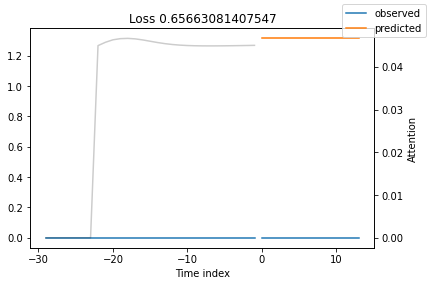

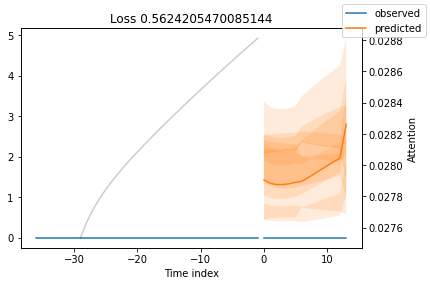

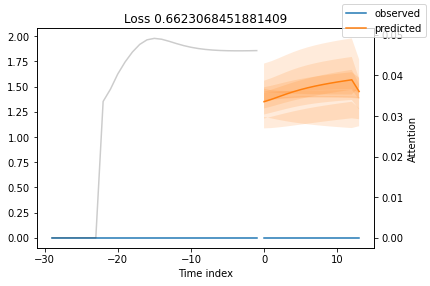

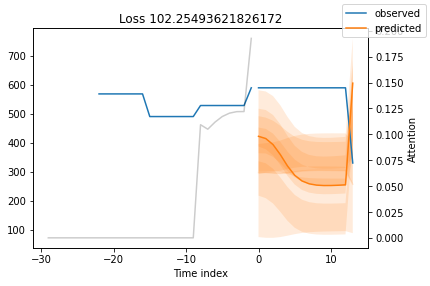

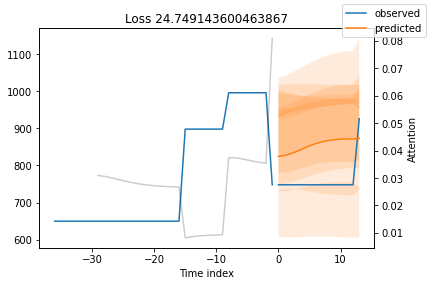

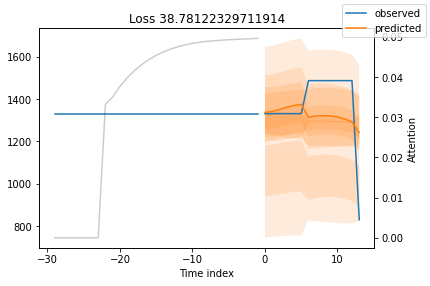

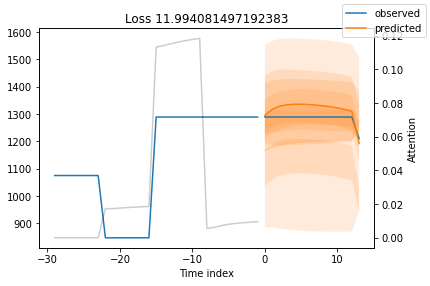

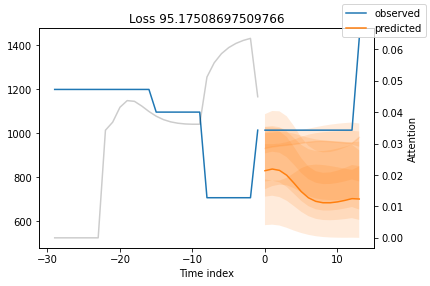

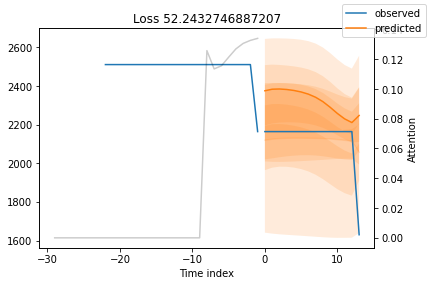

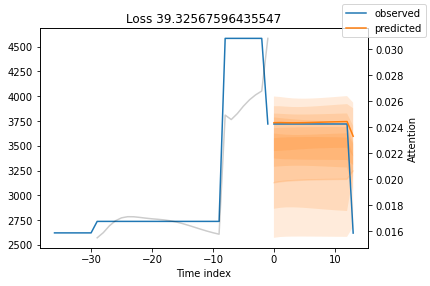

In [96]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

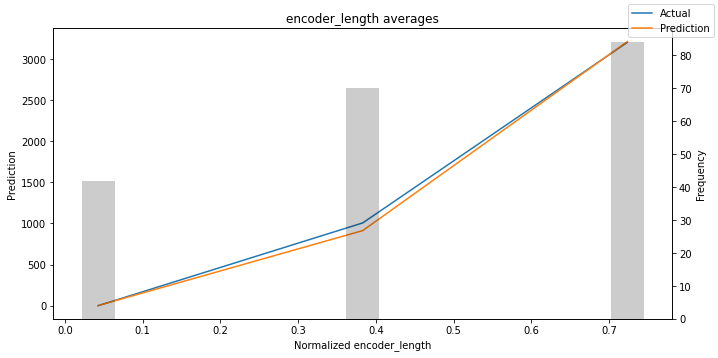

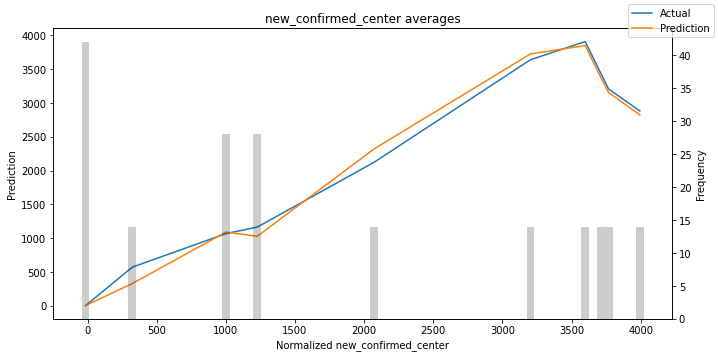

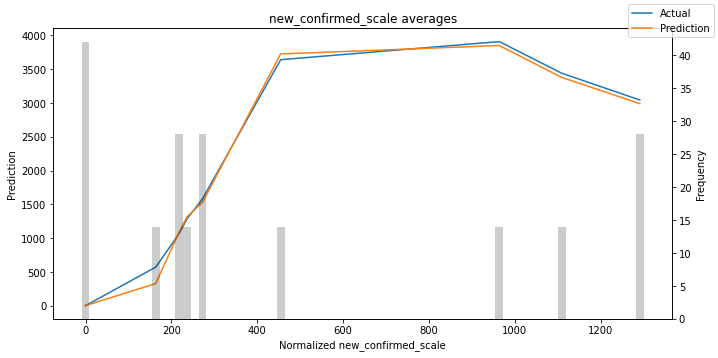

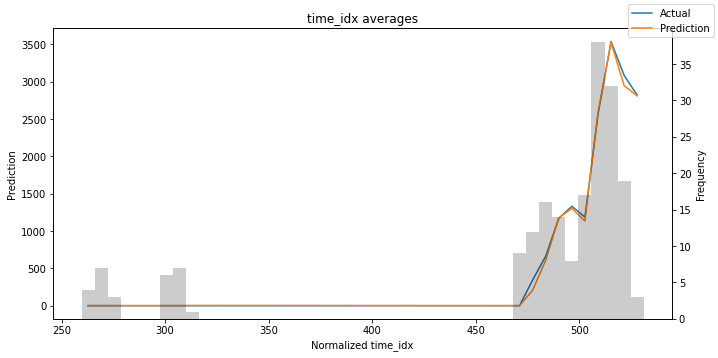

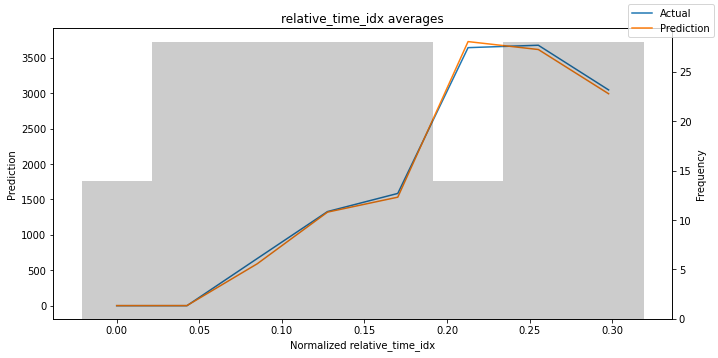

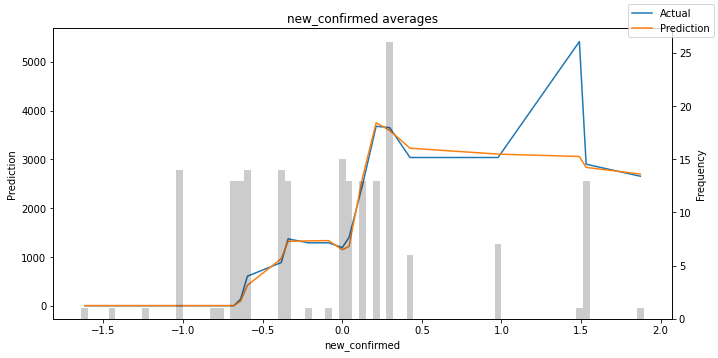

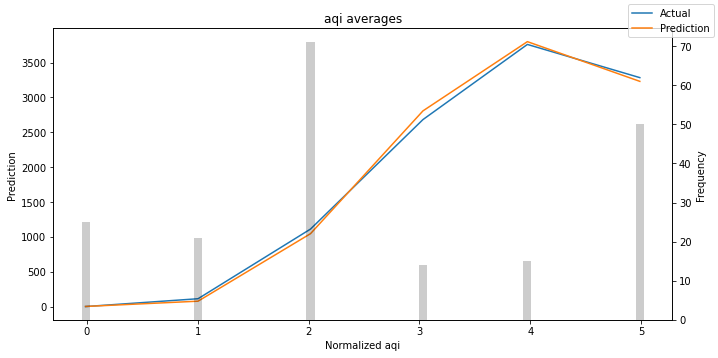

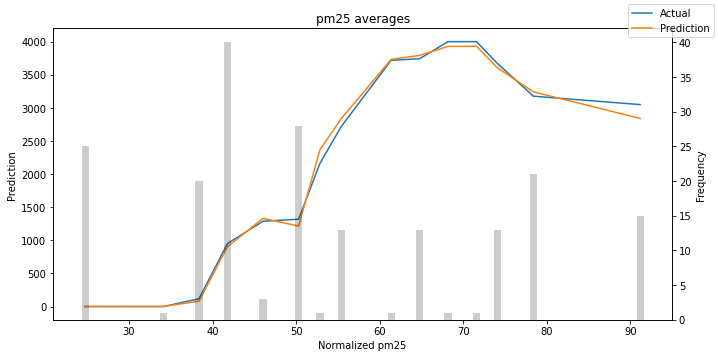

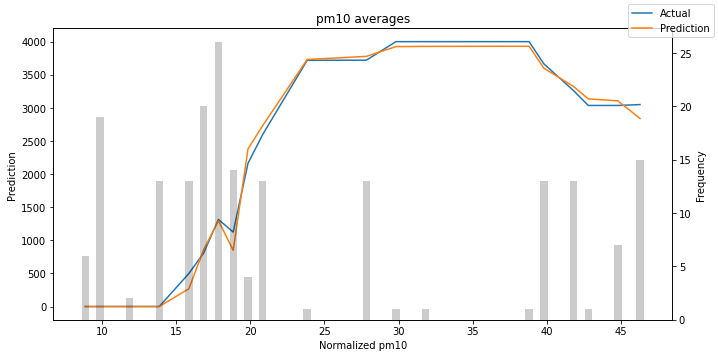

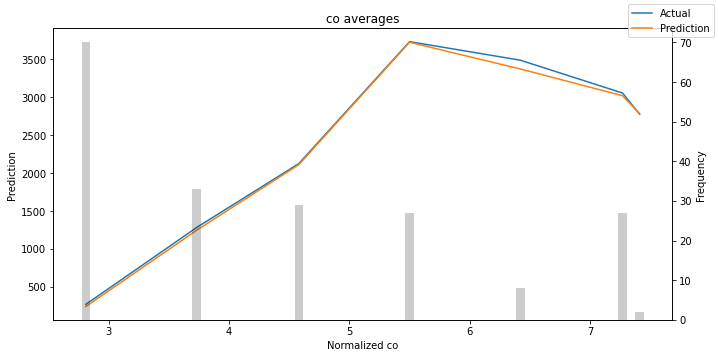

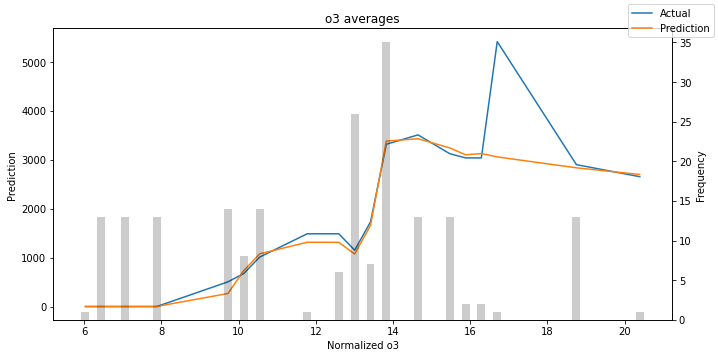

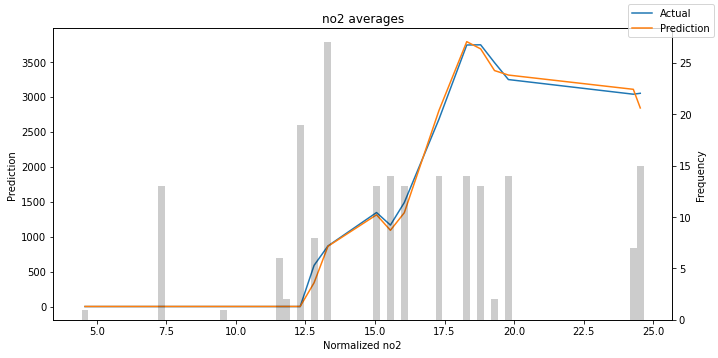

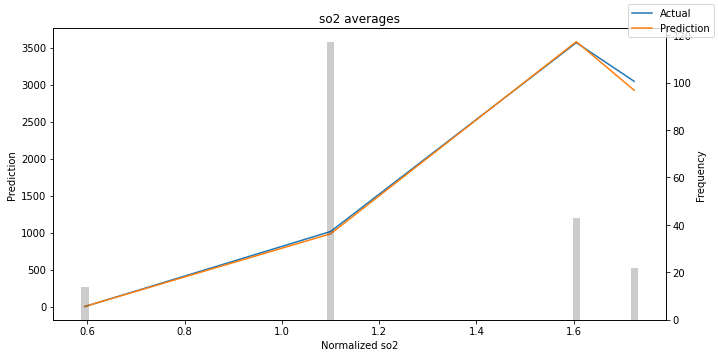

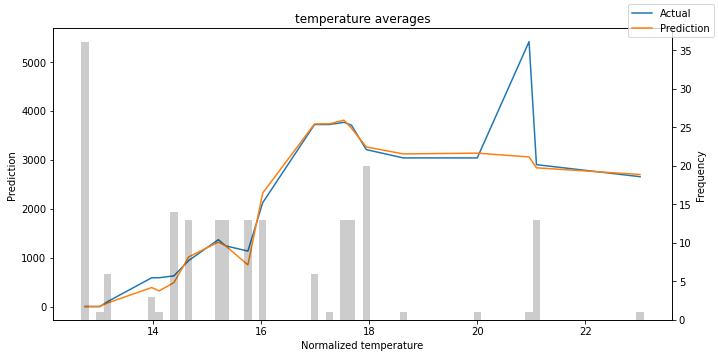

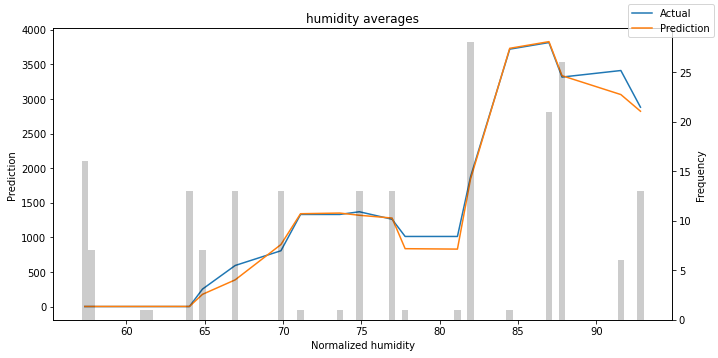

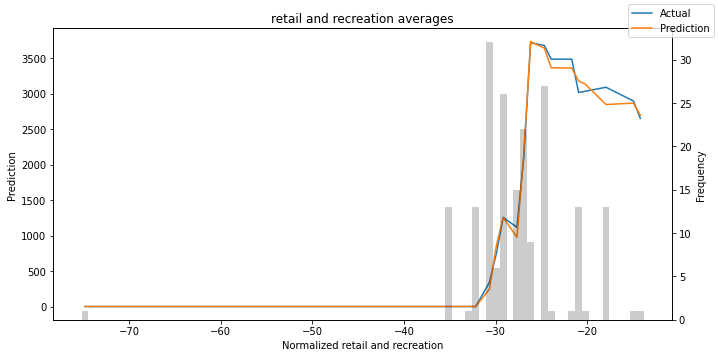

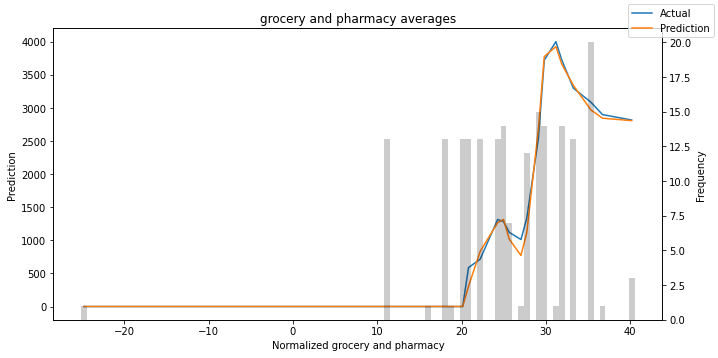

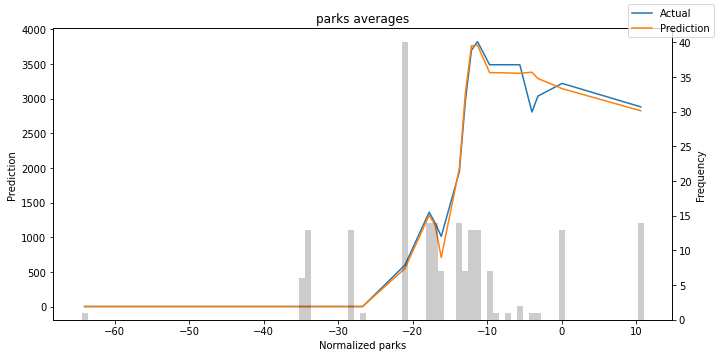

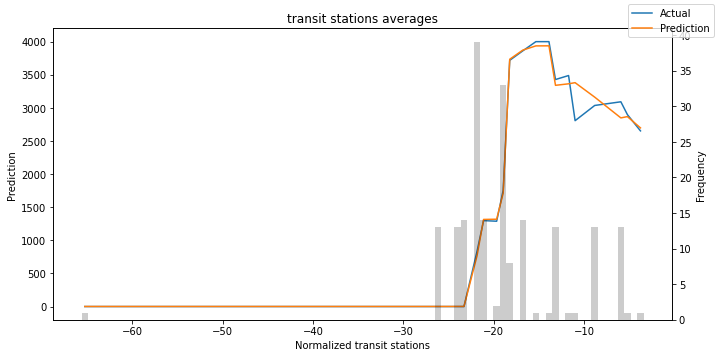

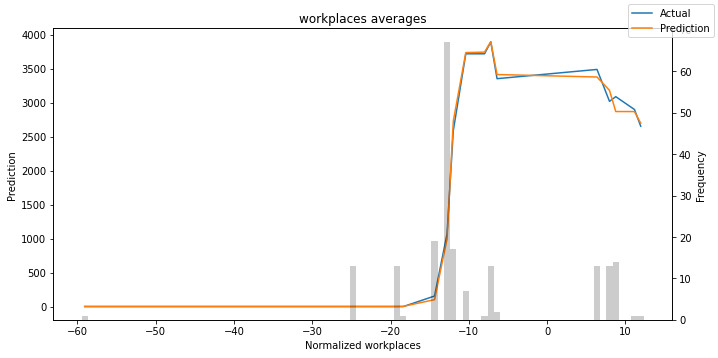

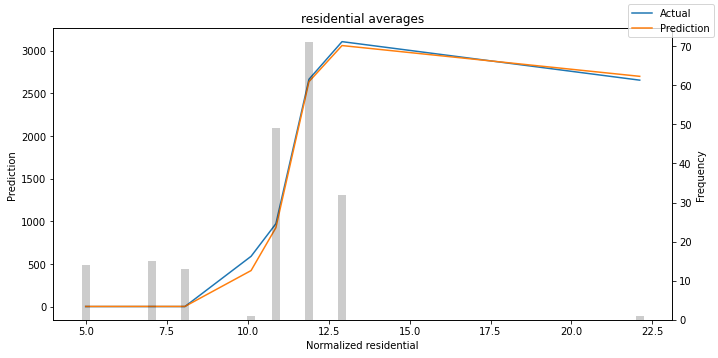

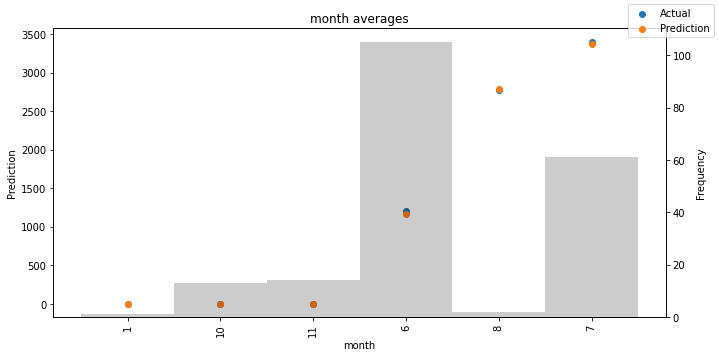

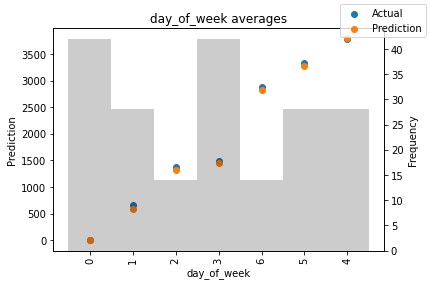

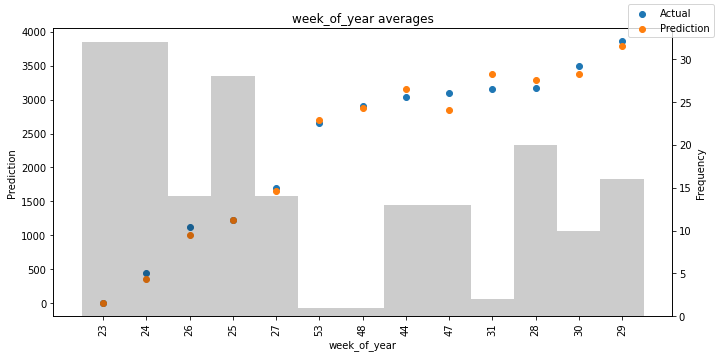

In [97]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [98]:
#select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length*5 + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

In [99]:
decoder_data

,date,aqi,pm25,pm10,co,o3,no2,so2,temperature,humidity,...,parks,transit stations,workplaces,residential,new_confirmed,time_idx,level,day_of_week,week_of_year,month
0,2021-09-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,528,0,3,31,8
1,2021-10-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,529,0,3,31,8
2,2021-11-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,530,0,3,31,8
3,2021-12-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,531,0,3,31,8
4,2022-01-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,532,0,3,31,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2027-02-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,593,0,3,31,8
66,2027-03-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,594,0,3,31,8
67,2027-04-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,595,0,3,31,8
68,2027-05-01,2,50.0,20.0,3.7,15.9,11.9,1.6,14.1,84.5,...,-7.0,-12.0,-6.0,10.0,0.0,596,0,3,31,8


In [100]:
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x522 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>}

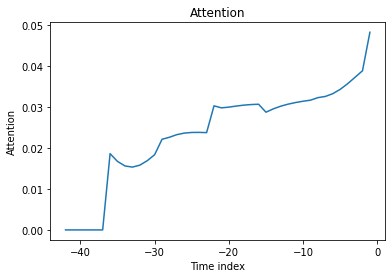

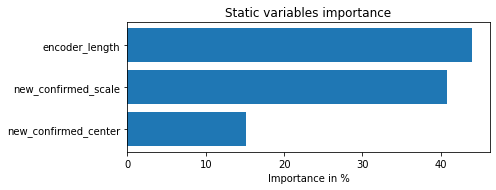

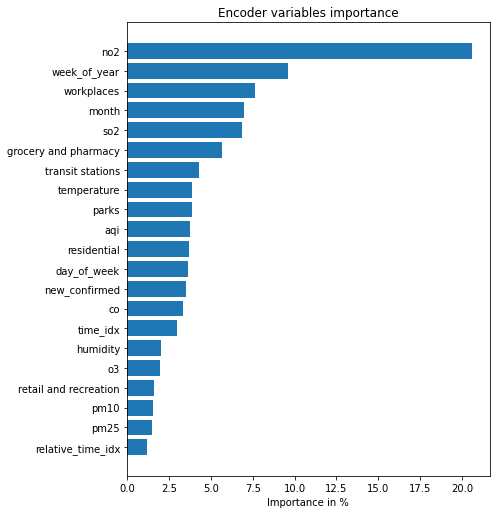

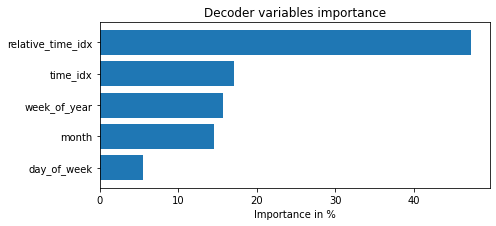

In [101]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)